In [96]:
import sqlite3 as lite
import pandas as pd
import re
import numpy as np
import ast

In [97]:
conn = lite.connect('cycling_big.db')

riders_df = pd.read_sql_query('SELECT * FROM riders;', conn)
races_df = pd.read_sql_query('SELECT * FROM race_results', conn)

# df = races_df.set_index('rider_id').join(riders_df.set_index('rider_id'))

conn.close()

"""
Convert the 'Date' column to DateTime format
Regarding races_df dataframe!
"""

races_df['Date'] = pd.to_datetime(races_df['Date'], errors='coerce', format='%d %B %Y')

# Remove rows where 'Date' is NaT
races_df = races_df.dropna(subset=['Date'])

# Normalize 'Date' to strip out time if it's present (this keeps just the date part)
races_df['Date'] = races_df['Date'].dt.normalize()

# Extract the month and year from the column and put them in their own columns
races_df['Month'] = races_df['Date'].dt.month
races_df['Year'] = races_df['Date'].dt.year

print("Unique values for 'months': ", races_df['Month'].unique(), "\n")
print("Unique values for 'years': ",races_df['Year'].unique())

"""
Converting the timetable to total seconds
"""

def time_to_seconds(time_str):
    # Remove commas and any spaces
    time_str = time_str.replace(',', '').strip()

    # Check the consistency of the time format using regular expressions
    match = re.match(r'(\d{1,2}):(\d{2}):(\d{2})', time_str)
    if match:
        hours, minutes, seconds = map(int, match.groups())
        total_seconds = hours * 3600 + minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan
        return total_seconds

    # Do the same as the loop above, but now for MM:SS format.
    match = re.match(r'(\d{1,2}):(\d{2})', time_str)
    if match:
        minutes, seconds = map(int, match.groups())
        total_seconds = minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan  
        return total_seconds

    # Do the same but for 0:00, 0:01, etc.
    match = re.match(r'(\d{1,2}):(\d{1,2})', time_str)
    if match:
        minutes, seconds = map(int, match.groups())
        total_seconds = minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan 
        return total_seconds
    
    # If format doesn't match, return NaN
    return np.nan

# Apply the conversion function to the 'Time' column
races_df['Time_seconds'] = races_df['Time'].apply(time_to_seconds)

# print(races_df[['Time', 'Time_seconds']].head(10))
# races_df.info()

"""
Converting timelag to total seconds
"""

def timelag_to_seconds(timelag_str):
    # Check if the timelag_str contains missing values
    if pd.isna(timelag_str):
        return np.nan

    timelag_str = timelag_str.lstrip('+').strip()

    match = re.match(r'(\d{1,2}):(\d{2}):(\d{2})', timelag_str)
    if match:
        hours, minutes, seconds = map(int, match.groups())
        return hours * 3600 + minutes * 60 + seconds

    match = re.match(r'(\d{1,2}):(\d{2})', timelag_str)
    if match:
        minutes, seconds = map(int, match.groups())
        return minutes * 60 + seconds
    
    match = re.match(r'(\d+):(\d+)', timelag_str)
    if match:
        minutes, seconds = map(int, match.groups())
        return minutes * 60 + seconds

    return np.nan

races_df['Timelag_seconds'] = races_df['Timelag'].apply(timelag_to_seconds)

races_df['Timelag_seconds'] = races_df['Timelag_seconds'].replace(0.0, np.nan)

print(races_df[['Timelag', 'Timelag_seconds']].head(10))

"""
Converting distance into single numerical value
This means stripping 'km' from string and converting the remaining values into float64
"""

races_df['Length'] = races_df['Length'].str.replace(' km', '', regex=False)

# Convert to numeric and replace 0 with NaN
races_df['Length'] = pd.to_numeric(races_df['Length'], errors='coerce')  # Convert to numeric and handle errors

# Replace 0 values with NaN
races_df['Length'] = races_df['Length'].replace(0.0, np.nan)

# print(races_df['Length'])

"""
Splitting values from 'rdr' and putting the split values into separate columns
"""

# Function to convert the 'rdr' string to separate ranking columns
def extract_rankings(rdr_str):
    try:
        # Converting str to dict
        rankings = ast.literal_eval(rdr_str)
        
        # Extracting ranks, while also handling missing keys
        pcs_rnk = rankings.get('PCS Ranking', np.nan)
        uci_rnk = rankings.get('UCI World Ranking', np.nan)
        alltime_rnk = rankings.get('Specials | All Time Ranking', np.nan)
        
        return pd.Series([pcs_rnk, uci_rnk, alltime_rnk])
    except:
        return pd.Series([np.nan, np.nan, np.nan])

# Apply the function to the 'rdr' column
riders_df[['PCS_Rnk', 'UCI_Rnk', 'AllTime_Rnk']] = riders_df['rdr'].apply(extract_rankings)

# Entries should be turned into numeric values, where errors get turned into NaN
riders_df['PCS_Rnk'] = pd.to_numeric(riders_df['PCS_Rnk'], errors='coerce')
riders_df['UCI_Rnk'] = pd.to_numeric(riders_df['UCI_Rnk'], errors='coerce')
riders_df['AllTime_Rnk'] = pd.to_numeric(riders_df['AllTime_Rnk'], errors='coerce')

# print(riders_df[['fullname', 'PCS_Rnk', 'UCI_Rnk', 'AllTime_Rnk']])

"""
Convert stage types to binary with label encoding
"""

races_df['Stage_Type_bin'] = races_df['Stage_Type'].map({'RR': 0, 'ITT': 1})

"""
Splitting values from 'pps' and putting those values into separate columns.
"""

def extract_points(pps_str):
    try:
        points = ast.literal_eval(pps_str)
        
        day_pnt = np.nan if points.get('One day races', '0') == '0' else points.get('One day races', np.nan)
        gc_pnt = np.nan if points.get('GC', '0') == '0' else points.get('GC', np.nan)
        tt_pnt = np.nan if points.get('Time trial', '0') == '0' else points.get('Time trial', np.nan)
        sprint_pnt = np.nan if points.get('Sprint', '0') == '0' else points.get('Sprint', np.nan)
        climb_pnt = np.nan if points.get('Climber', '0') == '0' else points.get('Climber', np.nan)
        
        return pd.Series([day_pnt, gc_pnt, tt_pnt, sprint_pnt, climb_pnt])
    except:
        return pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan])

riders_df[['Day_Pnt', 'GC_Pnt', 'TT_Pnt', 'Sprint_Pnt', 'Climb_Pnt']] = riders_df['pps'].apply(extract_points)

riders_df['Day_Pnt'] = pd.to_numeric(riders_df['Day_Pnt'], errors='coerce')
riders_df['GC_Pnt'] = pd.to_numeric(riders_df['GC_Pnt'], errors='coerce')
riders_df['TT_Pnt'] = pd.to_numeric(riders_df['TT_Pnt'], errors='coerce')
riders_df['Sprint_Pnt'] = pd.to_numeric(riders_df['Sprint_Pnt'], errors='coerce')
riders_df['Climb_Pnt'] = pd.to_numeric(riders_df['Climb_Pnt'], errors='coerce')

# print(riders_df[['fullname', 'Day_Pnt', 'GC_Pnt', 'TT_Pnt', 'Sprint_Pnt', 'Climb_Pnt']])


"""
Join the rider and race tables together, using the rider_id as an index
"""

df = races_df.set_index('rider_id').join(riders_df.set_index('rider_id'))

"""
Dropping columns that are not needed for analysis
"""

# Note: fix the long list
df.drop(['Time', 'Timelag', 'rdr', 'pps', 'birthdate', 'rider_url', 'Race_url', 'Stage_url', 'Circuit', 'Race_Name', 'Stage_Name', 'Start', 'Finish', 'Category', 'Stage_Type'], axis=1, inplace=True)

# Replace all remaining zero values with NaN
df = df.replace(0, np.nan)

print(df.isna().sum())
print("\ndone")

Unique values for 'months':  [ 1  3  4  5  6  7  8  9 10] 

Unique values for 'years':  [2012 2014 2015 2017 2018 2020 2021]
  Timelag  Timelag_seconds
0   +0:00              NaN
1   +0:04              4.0
2   +0:06              6.0
3   +0:10             10.0
4   +0:10             10.0
5   +0:10             10.0
6   +0:10             10.0
7   +0:10             10.0
8   +0:10             10.0
9   +0:10             10.0
id                     0
Rnk                    0
GC                 10059
BiB                    0
Rider                  0
Age                    0
Team                  26
UCI                77527
Pnt                69767
Date                   0
Race_ID             2386
Stage_Number           0
Length              6495
Month                  0
Year                   0
Time_seconds       18435
Timelag_seconds    11212
Stage_Type_bin     72484
fullname           34208
team               34208
country            34208
height             34260
weight             34266
PCS

In [98]:
from sklearn.impute import KNNImputer

# Create a copy of the DataFrame to avoid modifying the original
#df_imp = df.copy()
print("NaNs before imputing:\n", df.isna().sum())
df_imp = df.copy()

# Specify the columns to impute
columns_impute = ['Age', 'Length', 'height', 'weight']

# Initialize the KNNImputer with the number of neighbors (you can change n_neighbors)
knn_imputer = KNNImputer(n_neighbors=5)

# Perform KNN imputation on the selected columns
# Note: We apply KNN imputation only on the relevant columns to avoid modifying other columns
df_imp[columns_impute] = knn_imputer.fit_transform(df[columns_impute])

# Check if there are any missing values left
print("NaNs after imputing:\n", df_imp.isna().sum())

NaNs before imputing:
 id                     0
Rnk                    0
GC                 10059
BiB                    0
Rider                  0
Age                    0
Team                  26
UCI                77527
Pnt                69767
Date                   0
Race_ID             2386
Stage_Number           0
Length              6495
Month                  0
Year                   0
Time_seconds       18435
Timelag_seconds    11212
Stage_Type_bin     72484
fullname           34208
team               34208
country            34208
height             34260
weight             34266
PCS_Rnk            45842
UCI_Rnk            46804
AllTime_Rnk        53300
Day_Pnt            34216
GC_Pnt             34208
TT_Pnt             34631
Sprint_Pnt         34342
Climb_Pnt          34365
dtype: int64
NaNs after imputing:
 id                     0
Rnk                    0
GC                 10059
BiB                    0
Rider                  0
Age                    0
Team             

In [99]:
""" # Imputate outliers using IQR
# Define a function for defining IQR 
def iqr_detect(iqr_data):
    Q1 = iqr_data.quantile(0.25)
    Q3 = iqr_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (iqr_data < lower_bound) | (iqr_data > upper_bound)


numeric_columns = df_imp.select_dtypes(include=['float64', 'int64']).columns
columns_excl = ['id', 'Rnk', 'PCS_Rnk', 'UCI_Rnk', 'AllTime_Rnk', 'Stage_Type_bin', 'Race_ID', 'Stage_Number']
columns_iqr = [col for col in numeric_columns if col not in columns_excl]

iqr_data = df_imp[columns_iqr]
iqr_data = iqr_data.apply(pd.to_numeric, errors='coerce')

outliers = iqr_detect(iqr_data)
outliers = outliers.apply(pd.to_numeric, errors = 'coerce')
print(f"Number of outliers detected: {outliers.sum().sum()}")
print("Outliers:", iqr_data[outliers])

for col in columns_iqr:
    outliers_col = iqr_detect(iqr_data[col])
    print(f"Outliers in {col}: {sum(outliers_col)}")
    iqr_data = iqr_data[~outliers_col]  # Remove outliers for each column

print("Amount of NaNs:\n", iqr_data.isnull().sum()) """

' # Imputate outliers using IQR\n# Define a function for defining IQR \ndef iqr_detect(iqr_data):\n    Q1 = iqr_data.quantile(0.25)\n    Q3 = iqr_data.quantile(0.75)\n    IQR = Q3 - Q1\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n    return (iqr_data < lower_bound) | (iqr_data > upper_bound)\n\n\nnumeric_columns = df_imp.select_dtypes(include=[\'float64\', \'int64\']).columns\ncolumns_excl = [\'id\', \'Rnk\', \'PCS_Rnk\', \'UCI_Rnk\', \'AllTime_Rnk\', \'Stage_Type_bin\', \'Race_ID\', \'Stage_Number\']\ncolumns_iqr = [col for col in numeric_columns if col not in columns_excl]\n\niqr_data = df_imp[columns_iqr]\niqr_data = iqr_data.apply(pd.to_numeric, errors=\'coerce\')\n\noutliers = iqr_detect(iqr_data)\noutliers = outliers.apply(pd.to_numeric, errors = \'coerce\')\nprint(f"Number of outliers detected: {outliers.sum().sum()}")\nprint("Outliers:", iqr_data[outliers])\n\nfor col in columns_iqr:\n    outliers_col = iqr_detect(iqr_data[col])\n    print(f"Outliers in 

In [100]:
numeric_columns = df_imp.select_dtypes(include=['float64', 'int64']).columns
columns_excl = ['id', 'Rnk', 'PCS_Rnk', 'UCI_Rnk', 'AllTime_Rnk', 'Stage_Type_bin', 'Race_ID', 'Stage_Number']
columns_iqr = [col for col in numeric_columns if col not in columns_excl]

print("Old Shape: ", df_imp[columns_iqr].shape)

# IQR
# Calculate the upper and lower limits
Q1 = df_imp[columns_iqr].quantile(0.25)
Q3 = df_imp[columns_iqr].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
upper_outliers = df_imp[columns_iqr] >= upper
lower_outliers = df_imp[columns_iqr] <= lower
print(df_imp[columns_iqr].head())

outliers = upper_outliers | lower_outliers

outlier_indices = outliers.any(axis=1)

# Removing the outliers
df_imp.drop(index=df_imp[outlier_indices].index, inplace=True)

print("New Shape: ", df_imp[columns_iqr].shape)

Old Shape:  (80174, 14)
                                   GC   Age  UCI   Pnt  Length  Time_seconds  \
rider_id                                                                       
659ed585810c65fe22255a5e4a9b7838  1.0  29.0  6.0  50.0   149.0       16420.0   
None                              2.0  38.0  4.0  30.0   149.0           NaN   
None                              4.0  28.0  2.0  18.0   149.0           NaN   
13ed0fc8c2b0dcd2c4e1ac48b88166b8  8.0  26.0  1.0  13.0   149.0           NaN   
c0c77a7b1a8b55d9641962ba21981cab  9.0  31.0  1.0  10.0   149.0           NaN   

                                  Timelag_seconds  height  weight  Day_Pnt  \
rider_id                                                                     
659ed585810c65fe22255a5e4a9b7838              NaN   1.840    80.0   4650.0   
None                                          4.0   1.748    61.6      NaN   
None                                          6.0   1.822    66.4      NaN   
13ed0fc8c2b0dcd2c4e1ac48b

# PI7, Part  2: Dimension Reduction
The aim of dimension reduction is to extract features from a dataset to reduce the amount of imput features while still retaining their original values. This is an important step in using our dataset for machine learning. 

Why is this important?

When a dataset has a large amount of dimensions, the number of possible combinations of features will increase exponentially. This will make doing computations more difficult when trying to obtain representative samples of the data. If the algorithms need to process a large amount of data, it will computationally become very expensive. By simplifying our feature space, the complexity en computation time will drastically be decreased. Some machine learning models are also more sensitive to higher numbers of dimensions, which would, for the models, require more data to achieve the same level of accuracy than if they were using lower-dimensional data.

<!-- Curse of Dimensionality -->

#### 1.1: Principal Component Analysis
In this part of the assignment, PCA will be performed over the dataset. PCA is a linear dimension reduction technique that aims to simplify the representation of the relations between two or more variables.

PCA aims to capture directions which contain the most amount of variation into principle components. The first principle component will capture the most variance, the second will capture the second most variance and so on.

Let's first try PCA using two variables: the total points a cyclist gained during sprints and their weight. Below are the two variables visualised in a scatterplot.

        Sprint_Pnt       weight
count  1715.000000  1715.000000
mean    350.064723    66.608397
std     456.793513     5.579974
min       1.000000    55.000000
25%      75.000000    63.000000
50%     186.000000    67.000000
75%     377.000000    70.000000
max    2596.000000    81.000000


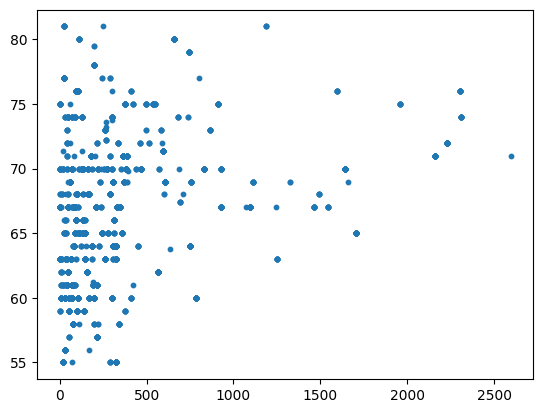

In [116]:
import matplotlib.pyplot as plt

# We will be using 2 dimensions, since we aim to describe 2 features of the dataset
d = 2

df_pca_ex = df_imp[['Sprint_Pnt', 'weight']].dropna()

plt.scatter(df_pca_ex['Sprint_Pnt'], df_pca_ex['weight'], s=10)

print(df_pca_ex.describe())

To make the two variables relative to another, we will use z-standardization.

$Z = \frac{X - \mu}{\sigma}$

In [102]:
df_pca_ex_z = (df_pca_ex - df_pca_ex.mean()) / df_pca_ex.std()

Now let's apply PCA for the first component.

/tmp/ipykernel_27741/1273697288.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax1.plot([pc1_start[0], pc1_end[0]], [pc1_start[1], pc1_end[1]], c='r', label='PC1 projection')


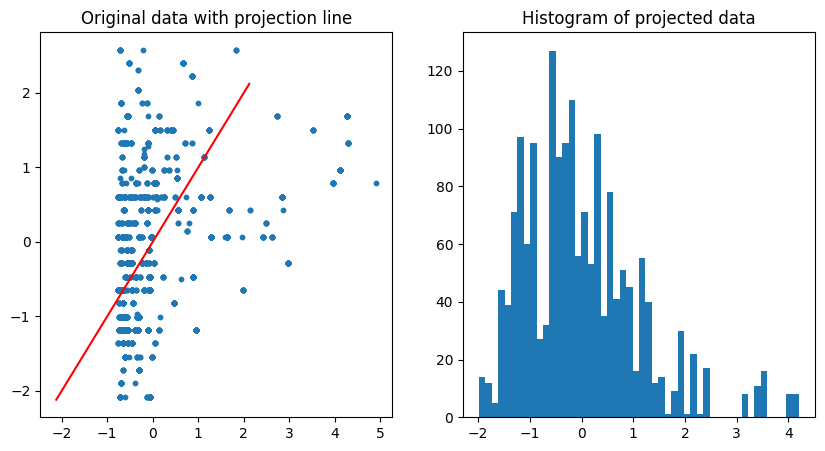

In [103]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1).fit(df_pca_ex_z)
df_proj = pca.transform(df_pca_ex_z)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(df_pca_ex_z['Sprint_Pnt'], df_pca_ex_z['weight'], s=10)

# Plot original data + PCA projection line
mean = df_pca_ex_z.mean()

# Extract the first principle component into an object
pc1 = pca.components_[0]

# Plot a line for the first principle component passing through the mean
# Apply an arbitrary scale of 3 for passing through the mean
pc1_start = mean - 3 * pc1
pc1_end = mean + 3 * pc1

ax1.plot([pc1_start[0], pc1_end[0]], [pc1_start[1], pc1_end[1]], c='r', label='PC1 projection')
ax1.set_title(f"Original data with projection line")

# histogram of projected data
ax2.hist(df_proj, bins=50)
ax2.set_title(f"Histogram of projected data")
plt.show()

Below we can prove that two features were reduced into a principal component.

In [104]:
df_pca_ex_z.shape, df_proj.shape

((1715, 2), (1715, 1))

##### Cumulative Variance Ratio
<!--  -->

In [105]:
pca.explained_variance_ratio_

array([0.63805069])

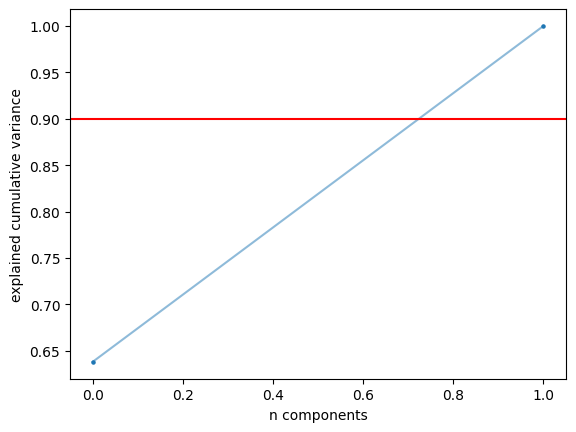

In [106]:
pca = PCA(n_components=df_pca_ex_z.shape[1]).fit(df_pca_ex_z)
X_proj = pca.transform(df_pca_ex_z)

cumulative_expl_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(pca.explained_variance_)), cumulative_expl_var, alpha=0.5)
plt.scatter(range(len(pca.explained_variance_)), cumulative_expl_var, s=5)
plt.xlabel("n components")
plt.ylabel("explained cumulative variance")
plt.axhline(0.9, color='red')

<BarContainer object of 2 artists>

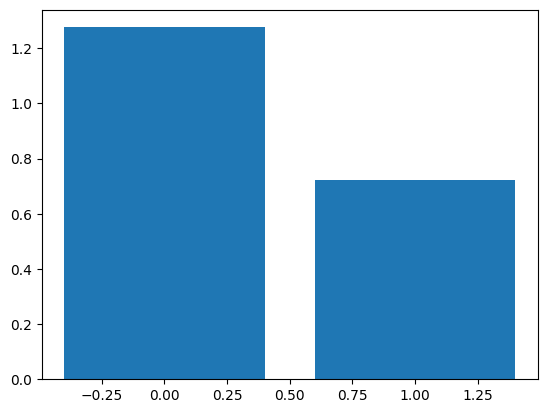

In [107]:
plt.bar(range(pca.explained_variance_.shape[0]), pca.explained_variance_)

#### 2. Classification and Regression Trees
Instead of PCA, other methods can be used for reducing columns and combining categories. One of these solutions is by using **Classification and Regression Trees** (CART). Classification trees are used for classification tasks and regression trees for prediction tasks. These trees operate by creating binary splits on the predictors that have the best claaisication/prediction of the outcome variable.

##### 2.1 Tree Structure
In CARTs, there are two types of nodes:
- **Decision Nodes**: these nodes, also called *splitting nodes* are responsible for giving information about records inside of the tree. These nodes pass on information about nodes below them and will always have a successor node. Say a record needed to be classified, whilst only the values for the predictor were known. Based on the rules, declared in the decision nodes, this record would be "dropped down" the tree until there were no successor nodes. Rules for decision making will be discussed in the section below.


- **Terminal Nodes**: these nodes, also called *tree leaves*, are final nodes in a tree that do not have any successor nodes. They are essentially the final output, based on decision making, where they represent the partitioning of data by *predictors* (also called attributes or independent variables).

##### 2.2 Decision making in classification
To classify a new record, where only the predictor variables are known, the position of this new record will be classified according to the values in the terminal node, where the destination for the new record is based on the condition(s) a *decision nodes* holds. According to the condition(s) of the decision node, the record will be split, corresponding to a nonacceptor (false) and an acceptor (true) classification. If the record is split into another decision node, the same process will repeat, but for the conditions of the following node. If there are no further decision nodes, the record will be classified at the terminal node and the process can repeat for a new record.

Say we drop a new record and it follows the conditions outlined by the decision node. Eventually the new record will reach it's terminal node. How will this new record be assigned to a class? The values (for numerical outcomes) or classifiers (for categorical outcomes) are stored in the terminal node. For numerical values, the average of all values stored will be used as a classifier, so the new record will be classified according to the average value. For categorical outcomes, classes are assigned based on a "vote", where the class of a node is determined by the most frequent class that belongs to that terminal node. These classifications are made during the instantiation of the tree.

##### 2.3 CART vs. PCA
In this section, the pros and cons for using CART over PCA will be discussed.

CART **pros**:
- CART selects features based on the predictive power of the target variable. This ensures that the features that are most relevant to the outcome are retained. PCA does not retain the predictive power of the target variable, making it possible that variance that is ireelevant to the outcome is retained. This is not necessarily a problem when choosing for PCA when there is no defined target variable.

- CART does not need data to be normalized or standardized, whereas PCA does. This reduces the number of steps that need to be taken during preprocessing when choosing for CART.

- CART retains the original form of features, whereas PCA uses principal components based on the linear combinations of features. This further abstraction of the interpretation of data post-PCA makes data produced from PCA harder to interpret.

- CART works with both numerical (regression) and categorical (classification), whereas PCA can only be done over numerical values.

- CART captures non-linear relationships between the features of a target variable, whereas PCA assumes a linear relationship between features. This means that PCA will not handle non-linear relationships as well as CART can.


CART **cons**:
- Tree structures are unstable since they can shift substantially based on the chosen sample.
- CART is sensitive to overfitting.
- 

#### 3. Why use dimension reduction

#### 4. K-mean clustering